In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

# (A) Nearest Stations

In [44]:
cd geocoding/

/Users/mohiuddi/Desktop/Courses/ADA/solarity/geocoding


In [45]:
import geocoding_functions as geo_fns
import location_functions as loc_fns
import station_info

## User input

In [46]:
address = "Route Cantonale 39B, 1025 St. Sulpice"

## Parameters

In [47]:
k = 3 ##Number of nearest neighbouring stations

### Get coordinates of the address

In [48]:
coordinates = geo_fns.getCoordinates(address)
if(coordinates is None):
    print("*** Invalid Address ***")
    print("Sample address: Route Cantonale 33, 1025 St. Sulpice")
    exit(0)

In [49]:
coordinates

(46.5159793, 6.5637658)

### Read pickled station info

In [50]:
station_df = pickle.load(open("station_df.p","rb"))

In [51]:
station_df.head()

,name,lat,lng
0,NAP,47.000000,7.933333
1,TAE,47.483333,8.900000
2,MTE,46.150000,7.616667
3,WSLNAF,46.666667,10.233333
4,UEB,47.350000,8.483333


### Get k nearest stations and their weights

In [52]:
neighbourNames = loc_fns.get_k_nearest_neighbours(coordinates, k, station_df)
neighbourWeights = loc_fns.get_weights_for_k_nearest(coordinates, k, station_df)

In [53]:
neighbourNames

45       PUY
17    WSLLAF
68       BIE
Name: name, dtype: object

In [54]:
neighbourWeights

array([ 0.4185834 ,  0.37991494,  0.20150166])

In [55]:
cd ..

/Users/mohiuddi/Desktop/Courses/ADA/solarity


# (B) Solar potential

In [56]:
means = pickle.load(open('learning/groupedStations.p', 'rb'))

In [57]:
meansAllFeatures = pickle.load(open('learning/groupedStationsAllFeatures.p', 'rb'))

In [58]:
def get_monthly_power_potential(stations, weights, means):
    potential = 0
    for i in range(len(stations)):
        potential = potential + means.power[stations[i]].get_values() * weights[i]
    
    return potential

In [59]:
monthly_potential = get_monthly_power_potential(neighbourNames.get_values(), neighbourWeights, means)

In [60]:
potential = np.mean(np.array(monthly_potential)) ## in Wp
potential

0.14828548713532164

In [61]:
monthly_potentialAllFeatures = get_monthly_power_potential(neighbourNames.get_values(), neighbourWeights, meansAllFeatures)

In [62]:
potentialAllFeatures = np.mean(np.array(monthly_potential)) ## in Wp
potentialAllFeatures

0.14828548713532164

TODO: Really? Exactly same? check

# (C) Installation Costs

## User input

In [19]:
averageElectricityBill = np.array([80]) ## CHF
roofArea = 30 ## m2

## Parameters

#### Electricity

In [20]:
elecTarrif = 0.20 ##CHF/Kwh

#### Solar

In [21]:
capacityPerPanel = 255 ## Wp
costPerPanel = 500 ## CHF
panelArea = 1.62 ## m2

## Average Consumption

In [22]:
hours = 24
days = 30
milli = 1000

In [23]:
avgEnergy = averageElectricityBill / elecTarrif
avgEnergy

array([ 400.])

In [24]:
avgPower = avgEnergy / (hours*days) ## Kw
avgPower

array([ 0.55555556])

## Solar Cost and Capacity

In [25]:
installation = np.array(range(5,101,5)) / 100

In [26]:
numPanels = np.floor(roofArea/panelArea)

In [27]:
capacity = installation * numPanels * capacityPerPanel / 1000 ## Kwp
cost = installation * numPanels * costPerPanel ## CHF
solarPower = capacity * potential ## in Kw

In [28]:
solarPower

array([ 0.03403152,  0.06806304,  0.10209456,  0.13612608,  0.1701576 ,
        0.20418912,  0.23822064,  0.27225215,  0.30628367,  0.34031519,
        0.37434671,  0.40837823,  0.44240975,  0.47644127,  0.51047279,
        0.54450431,  0.57853583,  0.61256735,  0.64659887,  0.68063039])

### Finding suitable installations

In [29]:
indx = solarPower <= avgPower
installationFinal = installation[indx]
installCapacity = capacity[indx]
installCost = cost[indx]
installPower = solarPower[indx]

In [30]:
solar_df = pd.DataFrame()
solar_df['capacity'] = installCapacity
solar_df['cost'] = installCost
solar_df['power'] = installPower
solar_df['installation'] = installationFinal
solar_df = solar_df.set_index('installation')
solar_df

,capacity,cost,power
installation,,,
0.05,0.2295,450.0,0.034032
0.10,0.4590,900.0,0.068063
0.15,0.6885,1350.0,0.102095
0.20,0.9180,1800.0,0.136126
0.25,1.1475,2250.0,0.170158
0.30,1.3770,2700.0,0.204189
0.35,1.6065,3150.0,0.238221
0.40,1.8360,3600.0,0.272252
0.45,2.0655,4050.0,0.306284


# (D) Savings and break-even time

In [31]:
def get_new_bill(bill, power):
    avgEnergyUsed = bill / elecTarrif
    avgEnergyUsed_daytime = avgEnergyUsed / 2
    nightUsage = avgEnergyUsed / 2

    avgEnergyProduced = power * hours * days
    
    newBill = np.empty(len(power))
    newUsageFromUtility = np.empty(len(power))
    for i in range(len(power)):
        dayUsage = max(0, avgEnergyUsed_daytime - avgEnergyProduced[i])
        newUsageFromUtility[i] = dayUsage + nightUsage
        newBill[i] = newUsageFromUtility[i] * elecTarrif

    return newBill, newUsageFromUtility

In [32]:
newBill, newUsage = get_new_bill(averageElectricityBill, installPower)

In [33]:
totalYears = 25
monthsInAYear = 12
def get_cummulative_savings(oldBill, newBill, cost):
    months = range(1, totalYears*monthsInAYear + 1)
    savings = np.empty((len(newBill), len(months)))
    for i in range(len(newBill)):
        eachMonth = oldBill - newBill[i]
        savings[i,:] = eachMonth*months - cost[i]
    return savings

In [34]:
savings = get_cummulative_savings(averageElectricityBill, newBill, installCost)

In [35]:
finalSavings = savings[:,-1]

In [36]:
def get_break_even_time(savings):
    nInstalls = savings.shape[0]
    breakEven = np.empty(nInstalls)
    for i in range(nInstalls):
        breakEven[i] = np.argmax(savings[i,:] > 0)

    return breakEven

In [37]:
breakEven = get_break_even_time(savings)/12

### Prettify Result

In [38]:
newBill

array([ 75.09946122,  70.19892244,  65.29838366,  60.39784488,
        55.49730611,  50.59676733,  45.69622855,  40.79568977,
        40.        ,  40.        ,  40.        ,  40.        ,
        40.        ,  40.        ,  40.        ,  40.        ])

In [39]:
final_df = solar_df
final_df['breakEvenYears'] = breakEven
final_df['savings_after_25yrs'] = finalSavings
final_df['annual_savings'] = finalSavings/totalYears
final_df

,capacity,cost,power,breakEvenYears,savings_after_25yrs,annual_savings
installation,,,,,,
0.05,0.2295,450.0,0.034032,7.583333,1020.161634,40.806465
0.10,0.4590,900.0,0.068063,7.583333,2040.323267,81.612931
0.15,0.6885,1350.0,0.102095,7.583333,3060.484901,122.419396
0.20,0.9180,1800.0,0.136126,7.583333,4080.646535,163.225861
0.25,1.1475,2250.0,0.170158,7.583333,5100.808168,204.032327
0.30,1.3770,2700.0,0.204189,7.583333,6120.969802,244.838792
0.35,1.6065,3150.0,0.238221,7.583333,7141.131436,285.645257
0.40,1.8360,3600.0,0.272252,7.583333,8161.293069,326.451723
0.45,2.0655,4050.0,0.306284,8.416667,7950.000000,318.000000


### Plot savings

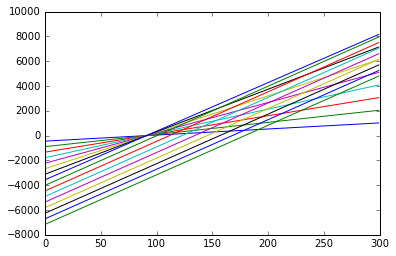

In [40]:
for i in range(savings.shape[0]):
    plt.plot(savings[i,:])